# Handsigns using tensorflow - recreation

This is an exercice to convert the Tensorflow based model in the OpenAI CNN course by Andrew Ng to a PyTorch based model.

For some function calls there are no direct equivalencies between the two frameworks. Examples include
* "SAME" padding in Tensorflow. In PyTorch you have to precompute the equivalent padding needed. In this model i use just pick a 0 or 1 padding
* No Need to define a backward propagation function. This handled by autograd
* The cost function softmax_cross_entropy_with_logits in Tensorflow. Replaced that with CrossEntroyLoss
* CrossEntropy loss expects a tensor of class indices not one-hot encoded data so we have to change that data
* Pytorch expects images to be in the format (channels x height x width). Tensorflow utilizes (height x width x channels)  




In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

# for python torch
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

%matplotlib inline
np.random.seed(1)


/Users/kofi/anaconda/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Use CUDA for PyTorch?
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#cudnn.benchmark = True

In [3]:
# Load the dataset
train_dataset = h5py.File('datasets/train_signs.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # training set of features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # training set of labels

test_dataset = h5py.File('datasets/test_signs.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set of features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set of labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig
#return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [4]:
# Reshape the training and test set labels data to be explicitly a row dataset
train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

y =2


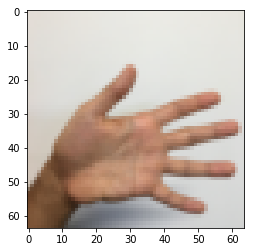

In [5]:
# Show an example image
plt.imshow(X_train_orig[0])
print("y =" + str(np.squeeze(Y_train_orig[10])))

In [6]:
# Normalize the image data to be between 0 and 1 (no need for this if using the torchvision transforms later)
X_train, X_test = X_train_orig , X_test_orig  
# convert to one hot encoding using the eye function which uses the identity matrix
# Y_train = np.eye(len(classes))[Y_train_orig.reshape(-1)]
# Y_test = np.eye(len(classes))[Y_test_orig.reshape(-1)]
Y_train, Y_test = Y_train_orig , Y_test_orig  
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080,)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120,)


In [7]:
# Create our CNN Model
class SignLangNet(nn.Module):
    def __init__(self, num_classes=6):
        '''
            initializes the model and defines the key convolution step their input parameters
        '''
        super(SignLangNet, self).__init__()
        # define the inputs to the model
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=8, stride=1, padding=2, kernel_size=(4,4))
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16, stride=1, padding=1, kernel_size=(2,2))
        # input size is previous conv2d f_h x f_w * out_channels  
        self.fc1 = nn.Linear(in_features=2*2*16,out_features=num_classes)
        
    def forward(self, x, show_msg = False):
        '''
            Implements the forward pass of the CNN. Uses the functional API for the pytorch
        '''
        if show_msg: print('Input size: ' + str(x.size()))
        # first layer
        x = self.conv1(x.float())
        if show_msg: print('Conv1 size: ' + str(x.size()))
        x = F.relu(x)
        if show_msg: print('Relu1 size: ' + str(x.size()))
        x = F.max_pool2d(input=x,kernel_size=(8,8), stride=(8,8), padding=0)
        if show_msg: print('Pool1 size' + str(x.size()))
        if show_msg: print()
            
        # second layer
        x = self.conv2(x.float())
        if show_msg: print('Conv2 size: ' + str(x.size()))
        x = F.relu(x)
        if show_msg: print('Relu2 size: ' + str(x.size()))
        x = F.max_pool2d(input=x,kernel_size=(4,4), stride=(4,4), padding=0)
        if show_msg: print('Pool2 size' + str(x.size()))
        
        
        ## below is the compact form of the above
        #x = F.max_pool2d(input=F.relu(self.conv1(x.float())), kernel_size=(1,8,8,1), stride=(8,8), padding=0)
        #print(x.size())
        #x = F.max_pool2d(input=F.relu(self.conv2(x.float())), kernel_size=(1,4,4,1), stride=(4,4), padding=0)
        #print(x.size())
        # then flatten the output ... 
        x = x.view(x.size(0), -1)  # x.view(-1, self.num_flat_features(x.float())) #
        if show_msg: print('Flatten size' + str(x.size()))

        if show_msg: print(self.fc1.weight.size())
        # ... and apply the fully connected layer
        x = self.fc1(x)
        if show_msg: print('Fully connected size' + str(x.size()))
        
        return x
        
    def num_flat_features(self, x):
        # get the size of the data excluding the batch size i presume
        size = x.size()[1:]
        num_features = 1
        # multiply the dimensions ... could use numpy here but that introduces another library dependency
        for s in size:
            num_features *= s
        return num_features


In [8]:
# What does the network look like
net = SignLangNet()
print(net)

SignLangNet(
  (conv1): Conv2d(3, 8, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=64, out_features=6, bias=True)
)


In [9]:
# define some transforms to change our data from numpy image format 
# ( batches x n_H x n_W x n_channels) to ( batches x n_channels x n_H x n_W )
img_transforms = transforms.Compose([
        transforms.ToPILImage(), # TorchVision can only work on PIL image
        transforms.ToTensor()    # magic call to reshape and normalize the data
])

In [10]:
class SignDataset(Dataset):
    def __init__(self, data, labels): #, mean, std):
        # get the shape of the numpy array
        #print(data.shape)
        num_imgs, img_h, img_w, num_channels = data.shape
        # initialize the data in the dataset
        # take note that pytorch image format is different
        self.data = data #torch.from_numpy(data)) #torch.from_numpy(data) #np.moveaxis(data,-1,1))
            #data.reshape(num_imgs,num_channels, img_h, img_w))
        #print(self.data.size())
        self.labels = torch.from_numpy(labels)
        #self.mean = mean
        #self.std = std
        #normalize here or in __getitem__

    def __getitem__(self, index):
        # apply the transforms to the 
        X = img_transforms(self.data[index]) 
        y = self.labels[index]
        return X, y

    def __len__(self):
        return len(self.data)

In [11]:
# # create a minibatch. this does requires using numpy arrays not the pytorch dataset and dataloader classes
# def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
#     """
#     Creates a list of random minibatches from (X, Y)
    
#     Arguments:
#     X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
#     Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
#     mini_batch_size - size of the mini-batches, integer
#     seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
#     Returns:
#     mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
#     """
    
#     m = X.shape[0]                  # number of training examples
#     mini_batches = []
#     np.random.seed(seed)
    
#     print(Y.shape)
#     # Step 1: Shuffle (X, Y)
#     permutation = list(np.random.permutation(m))
#     shuffled_X = X[permutation,:,:,:]
#     shuffled_Y = Y[permutation,:]

#     # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
#     num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
#     for k in range(0, num_complete_minibatches):
#         mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
#         mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
#         mini_batch = (mini_batch_X, mini_batch_Y)
#         mini_batches.append(mini_batch)
    
#     # Handling the end case (last mini-batch < mini_batch_size)
#     if m % mini_batch_size != 0:
#         mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
#         mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
#         mini_batch = (mini_batch_X, mini_batch_Y)
#         mini_batches.append(mini_batch)
    
#     return mini_batches

In [12]:
# define the cost function and associated parameters
learning_rate = 0.005
momentum = 0.9
# use the softmax cross entropy loss function as the cost
criterion = nn.CrossEntropyLoss()
# use stochastic gradient descent in this case with learning rate and momentum parameters
#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
# use Adam gradient descent in this case with learning rate and weight decay
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay=0.0001)

In [13]:
# create a learning rate adustment
def learning_rate_schedule(epoch, lr):
    
    # reduce by a factor of ten
    t = epoch / 10
    if t % 2 == 0:
        lr = lr/ pow(10,t/2) 
    # then update the learning rate parameter
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [14]:
# Run the iterative batched optiimization to find the correct optimal values for the net.parameters
def sign_model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009, num_epochs= 1000,
              mini_batch_size = 64, print_cost = True):
    
    # initialize the random seed for the entire run ... doing this because we are doing our own data handling a
    # and not using the trainloader facility in pytorch
    seed = 3
    num_examples, img_height, img_width, img_chan = X_train.shape
    #print(num_examples)
    
    epoch_costs = []
    costs = []
    
    for epoch in range(num_epochs):

        running_loss = 0.0
        # Using the Numpy dataset ... 
        ## how many minibatches overall
        num_minibatches = int (num_examples / mini_batch_size)
        ## use the same seed for each epoch
        seed = seed + 1
        
        # Using native pytorch Dataset and DataLoader classes
        # https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
        train_dataset = SignDataset(X_train, Y_train)
        trainloader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=False, num_workers=1)

        ## i here is looping over the minibatch not the entire dataset
        ## this is because we are iterating over the trainloader object
        mbcounter = 1
        mbcost = 0.
        #for minibatch in minibatches:
        for minibatch in trainloader: #enumerate(trainloader,0):
            
            
            # we first get the batch input data and the corresponding labels
            inputs, labels = minibatch
            if use_cuda:
                inputs, labels = inputs.to(device), labels.to(device)
            
#             ## lets take a sneak peak at one of our images
#             t_img = inputs[0,1,:,:]*255
#             print(t_img)
#             plt.imshow(t_img)
#             print("y =" + str(np.squeeze(Y_train_orig[0])))
#             assert(1==-1)

            # clear or zero out the gradients computed from the previous iteration
            optimizer.zero_grad()

            # forward + backward + optimize
            # run the inputs through the network and get the corresponding outputs
            outputs = net(inputs)

            
            # CrossEntropy loss expects a tensor of class indices not one-hot encoded data so change that
            class_labels = labels #torch.max(labels, 1)[1]
            # then we also need to format the labels as longs
            class_labels  = class_labels.long()
            # compute the loss
            #print(torch.max(labels, 1)[1])
            loss = criterion(outputs, class_labels)
            # then run the backward pass .... using autograd because we obviously didnt define the bakward prop
            loss.backward()
            optimizer.step()
            
            
            # print the run statistics
            l = loss.item()
            running_loss += l
            costs.append(l)

            if print_cost == True and (mbcounter ) % int(num_minibatches * 0.5) == 0:
                print('Epoch:%d, MiniBatch: %d, has loss: %3f' %
                     (epoch + 1, mbcounter + 1, running_loss / (mbcounter +1)))
                #print ("Cost for batch %i: %f" % (mbcounter, running_loss))
        
            if mbcounter == num_minibatches:
                epoch_costs.append(running_loss / num_minibatches)
                print('Epoch %d: %5f' % (epoch, running_loss / num_minibatches))
                running_loss = 0.
            
            mbcounter += 1
        
        learning_rate_schedule(epoch, learning_rate)
        
    print("\nFinished Training")

    #print(epoch_costs)
    plt.plot(np.squeeze(epoch_costs))
    #plt.plot(np.squeeze(mb))
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    

In [15]:
def get_accuracy(X_data, Y_data, which_data='Training'):
    # Predict the model accuracy on any set of input data
    accu  = 0.
    total = 0.
    my_dataset = SignDataset(X_data, Y_data)
    trainloader = DataLoader(my_dataset, batch_size=1, shuffle=False, num_workers=1)
    with torch.no_grad():
        for data in trainloader: #zip(X_data, Y_data):
            inputs, labels = data
            if use_cuda:
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(torch.tensor(inputs))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            #correct += (predicted - torch.max(labels, 1)[1].long()).sum().item()
            #print("{} - {} ".format(int(predicted), int(torch.max(labels, 1)[1].long())))
            if int(predicted) == int(labels): #int(torch.max(labels, 1)[1].long()):
                accu += 1
            #accu += sum((int(predicted) == int(torch.max(labels, 1)[1].long()))*1)
    accu = 100 * accu/total
    print('%s accuracy is %.3f%%' % (which_data, accu))

Epoch 0: 1.794579
Epoch 1: 1.789950
Epoch 2: 1.783625
Epoch 3: 1.764883
Epoch 4: 1.706022
Epoch 5: 1.586444
Epoch 6: 1.459468
Epoch 7: 1.339162
Epoch 8: 1.216426
Epoch 9: 1.112919
Epoch 10: 1.022838
Epoch 11: 0.957596
Epoch 12: 0.910687
Epoch 13: 0.863038
Epoch 14: 0.825925
Epoch 15: 0.794982
Epoch 16: 0.773313
Epoch 17: 0.750469
Epoch 18: 0.713617
Epoch 19: 0.684746
Epoch 20: 0.661223
Epoch 21: 0.614101
Epoch 22: 0.620030
Epoch 23: 0.587589
Epoch 24: 0.570188
Epoch 25: 0.557412
Epoch 26: 0.543243
Epoch 27: 0.530181
Epoch 28: 0.514002
Epoch 29: 0.502356
Epoch 30: 0.487276
Epoch 31: 0.471035
Epoch 32: 0.456699
Epoch 33: 0.442912
Epoch 34: 0.431316
Epoch 35: 0.420554
Epoch 36: 0.410960
Epoch 37: 0.400018
Epoch 38: 0.393569
Epoch 39: 0.382436
Epoch 40: 0.375792
Epoch 41: 0.362232
Epoch 42: 0.397604
Epoch 43: 0.373469
Epoch 44: 0.359507
Epoch 45: 0.347704
Epoch 46: 0.338808
Epoch 47: 0.331963
Epoch 48: 0.326153
Epoch 49: 0.317890
Epoch 50: 0.309515
Epoch 51: 0.305619
Epoch 52: 0.297912
Epo

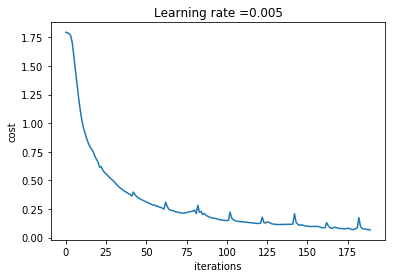

In [16]:
optimizer.zero_grad()
num_epochs = 190
mini_batch_size = 64
sign_model(X_train, Y_train, X_test, Y_test, learning_rate, 
           num_epochs,mini_batch_size=mini_batch_size, print_cost=False)

In [17]:
get_accuracy(X_train, Y_train)

Training accuracy is 98.519%


In [18]:
get_accuracy(X_test, Y_test, "Test")

Test accuracy is 85.833%
